https://python.langchain.com/docs/tutorials/qa_chat_history/  

在许多问答应用程序中，我们希望允许用户进行来回对话，这意味着应用程序需要某种形式的“记忆”来记录过去的问题和答案，并且需要一些逻辑来将这些信息整合到当前的思考中。  
  
这是多部分教程的第二部分：  
  
- 第一部分介绍了RAG（检索增强生成）并 walkthrough（逐步演示）了一个最小实现。  
- 第二部分（本指南）扩展了实现以适应对话式的交互和多步骤的检索过程。  
  
在这里，我们将专注于添加整合历史消息的逻辑，这涉及到聊天记录的管理。  
我们将介绍两种方法：  
  
- **Chain**，其中我们最多执行一个检索步骤；  
- **Agent**，其中我们给予语言模型（LLM）执行多个检索步骤的自由裁量权。  

In [ ]:
# 如果要使用LangSmith，可到LangSmith网站上申请key，然后打开下面的代码。

"""
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
"""

In [2]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(
    #model_name="deepseek-r1:32b",
    model_name="qwen2",
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=False
)

In [3]:
from langchain.embeddings import HuggingFaceEmbeddings

# 初始化 Hugging Face 嵌入模型
embeddings = HuggingFaceEmbeddings()

/tmp/ipykernel_495442/127560303.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
/tmp/ipykernel_495442/127560303.py:4: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()
/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Chains  
  
首先，让我们重新回顾在第一部分中构建的向量存储，它对Lilian Weng撰写的《LLM驱动的自主代理》博客文章进行了索引。  

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

在RAG教程的第一部分中，我们将用户输入（question）、检索到的上下文（context）和生成的答案（answer）表示为状态中的独立键。对话体验可以自然地通过一系列消息来表示。除了来自用户和助手的消息外，检索到的文档和其他artifacts也可以通过tool message融入到消息序列中。这促使我们使用一系列消息来表示RAG应用程序的状态。具体来说，我们将拥有：  
  
用户输入作为HumanMessage；  
向量存储查询作为带有工具调用的AIMessage；  
检索到的文档作为ToolMessage；  
最终响应作为AIMessage。  

In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

利用tool-calling来与检索步骤交互还有另一个好处，那就是检索的query是由我们的模型生成的。这在对话场景中尤为重要，因为用户查询可能需要依据聊天历史。例如，考虑以下对话：  
  
人类：“什么是任务分解？”  
AI：“任务分解涉及将复杂的任务分解为更小、更简单的步骤，以便代理或模型更易于管理。”  
人类：“常见的做法有哪些？”  
  
在这种情况下，模型可以生成如“任务分解的常见方法”这样的查询。工具调用自然地促进了这一点。正如RAG教程part 1的查询分析部分所提到的，这允许模型将用户查询重写为更有效的搜索查询。它还支持不涉及检索步骤的直接响应（例如，回应用户的通用问候）。  
  
现在让我们把检索步骤转换成一个工具。  

In [8]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

我们的图将由三个节点组成：  
  
一个处理用户输入的节点，要么为检索器生成查询，要么直接响应；  
一个用于执行检索步骤的检索工具节点；  
一个使用检索到的上下文生成最终响应的节点。  
我们在下面构建它们。请注意，我们利用了另一个预构建的LangGraph组件，即ToolNode，它执行工具并将结果作为ToolMessage添加到状态中。  

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

最后，我们将应用程序编译成一个单一的图对象。在这个例子中，我们只是将这些步骤连接成一个序列。我们还允许第一个query_or_respond步骤在不生成工具调用的情况下“短路”并直接响应用户。这使得我们的应用程序能够支持对话体验——例如，回应可能不需要检索步骤的通用问候。

In [10]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

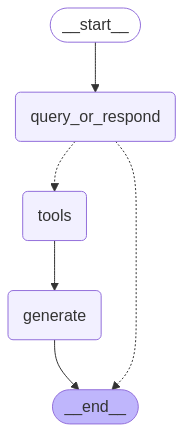

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

让我们测试一下我们的应用程序。  
  
请注意，它能够适当地响应那些不需要额外检索步骤的消息：  

In [12]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How may I assist you today?


并且在执行搜索时，我们可以流式传输这些steps以观察查询生成、检索和答案生成的过程：

In [13]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_x7j2wxhc)
 Call ID: call_x7j2wxhc
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", 

具有状态管理的聊天记录  
  
在生产中，问答应用程序通常会将聊天记录持久化到数据库中，并能够适当地读取和更新这些记录。  
  
LangGraph实现了一个内置的持久层，这使其成为支持多轮对话的应用程序的理想选择。  
  
要管理多个对话轮次和线程，我们只需在编译应用程序时指定一个检查点即可。由于图中的节点正在向状态添加消息，我们将能够在调用之间保持一致的聊天记录。  
  
LangGraph提供了一个简单的内存内检查点工具，我们在下面使用它。更多详情，请参阅其文档，包括如何使用不同的持久化后端（例如SQLite或Postgres）。  

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

我们现在可以像之前一样进行调用：

In [15]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_pc123te8)
 Call ID: call_pc123te8
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", 

In [16]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_1eie9v66)
 Call ID: call_1eie9v66
  Args:
    query: Common Ways of Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are t

Agent  
  
代理利用LLM的推理能力在执行过程中做出决策。使用代理可以让你将更多的检索过程控制权下放。虽然它们的行为比上述“chain”更难以预测，但它们能够为一个查询执行多个检索步骤，或者对单一搜索进行迭代。  
  
下面我们将组装一个最小的RAG代理。通过使用LangGraph的预构建ReAct代理构造器，我们可以用一行代码完成这项工作。  

In [17]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

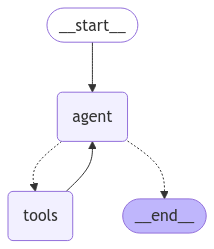

In [18]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

与我们之前的实现的关键区别在于，这里不是以最终generate step结束运行，而是the tool invocation loops back to the original LLM call。然后，模型可以使用检索到的上下文来回答问题，或者生成另一个工具调用来获取更多信息。  
  
让我们来测试一下。我们构造一个通常需要一系列迭代的检索步骤才能回答的问题：  

In [19]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_24cnb7bv)
 Call ID: call_24cnb7bv
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can 